In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
# np.random.seed(42)

In [121]:
# ============================================================
# 1) SETUP & GLOBAL OPTIONS
# ============================================================
pd.set_option("display.precision", 4)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)

# Modern DataFrame styling functions
def clean_table(df):
    return (
        df.style
        .background_gradient(cmap="Blues", axis=None, 
                             vmin=df.min().min(), vmax=df.max().max())
        .set_properties(**{
            'border': '0px solid white',
            'padding': '6px 12px',
            'font-size': '12pt'
        })
        .set_table_styles([
            {"selector": "thead th", 
             "props": [("background-color", "#e6e6e6"), 
                       ("color", "#333"), 
                       ("font-size", "12pt"),
                       ("font-weight", "bold"),
                       ("border-bottom", "1px solid #999")]}
        ])
        .format("{:,.4f}")
    )

def minimal(df):
    return (
        df.style
        .set_properties(**{
            'border': '0px',
            'padding': '4px 10px',
            'font-size': '12pt'
        })
        .set_table_styles([
            {"selector": "thead th",
             "props": [("background-color", "white"),
                       ("color", "#222"),
                       ("font-weight", "bold"),
                       ("font-size", "12pt"),
                       ("border-bottom", "2px solid #e3e3e3")]}
        ])
        .format("{:,.4f}")
    )


In [ ]:
# ============================================================
# 2) MARKET SIMULATOR
# ============================================================
def generate_white_noise_prices(n=10000, S0=100, vol=0.01):
    """
    White-noise price simulator (random walk with normal returns)
    """
    returns = np.random.normal(0, vol, n)
    prices = S0 * np.cumprod(1 + returns)
    df = pd.DataFrame({"price": prices})
    df.index.name = "t"
    return df

df = generate_white_noise_prices()
df.head()


,price
t,
0,101.7257
1,101.8496
2,102.6170
3,102.7194
4,102.0340


In [123]:
# ============================================================
# 3) STRATEGY FUNCTIONS
# ============================================================
def buy_and_hold(df):
    """Always long"""
    return pd.Series(1, index=df.index)

def simple_momentum(df):
    """Long if price increased yesterday, short if decreased"""
    sig = np.sign(df["price"].diff())
    sig.iloc[0] = 0
    return sig

def mean_reversion(df, window=5):
    """Short if price > MA, long if price < MA"""
    ma = df["price"].rolling(window).mean()
    sig = -np.sign(df["price"] - ma)
    sig.fillna(0, inplace=True)
    return sig



In [124]:
# ============================================================
# 4) BACKTEST ENGINE
# ============================================================
def backtest(df, signal, initial_capital=1_000_000, trade_size=1000):
    """
    Simple long/short backtesting engine.
    signal: Series taking values in {-1, 0, 1}
    """
    df = df.copy()
    df["signal"] = signal

    cash = initial_capital
    position = 0

    cash_list = []
    pos_list = []
    eq_list = []

    for t in df.index:
        price = df.loc[t, "price"]
        sig = df.loc[t, "signal"]

        target_pos = sig * trade_size
        trade = target_pos - position

        cash -= trade * price
        position = target_pos
        equity = cash + position * price

        cash_list.append(cash)
        pos_list.append(position)
        eq_list.append(equity)

    df["cash"] = cash_list
    df["position"] = pos_list
    df["equity"] = eq_list

    return df



In [125]:
# ============================================================
# 5) RUN MULTIPLE STRATEGIES
# ============================================================
strategies = {
    "Buy & Hold": buy_and_hold,
    "Momentum": simple_momentum,
    "Mean Reversion": mean_reversion,
}

results = {}

for name, func in strategies.items():
    sig = func(df)
    results[name] = backtest(df, sig)


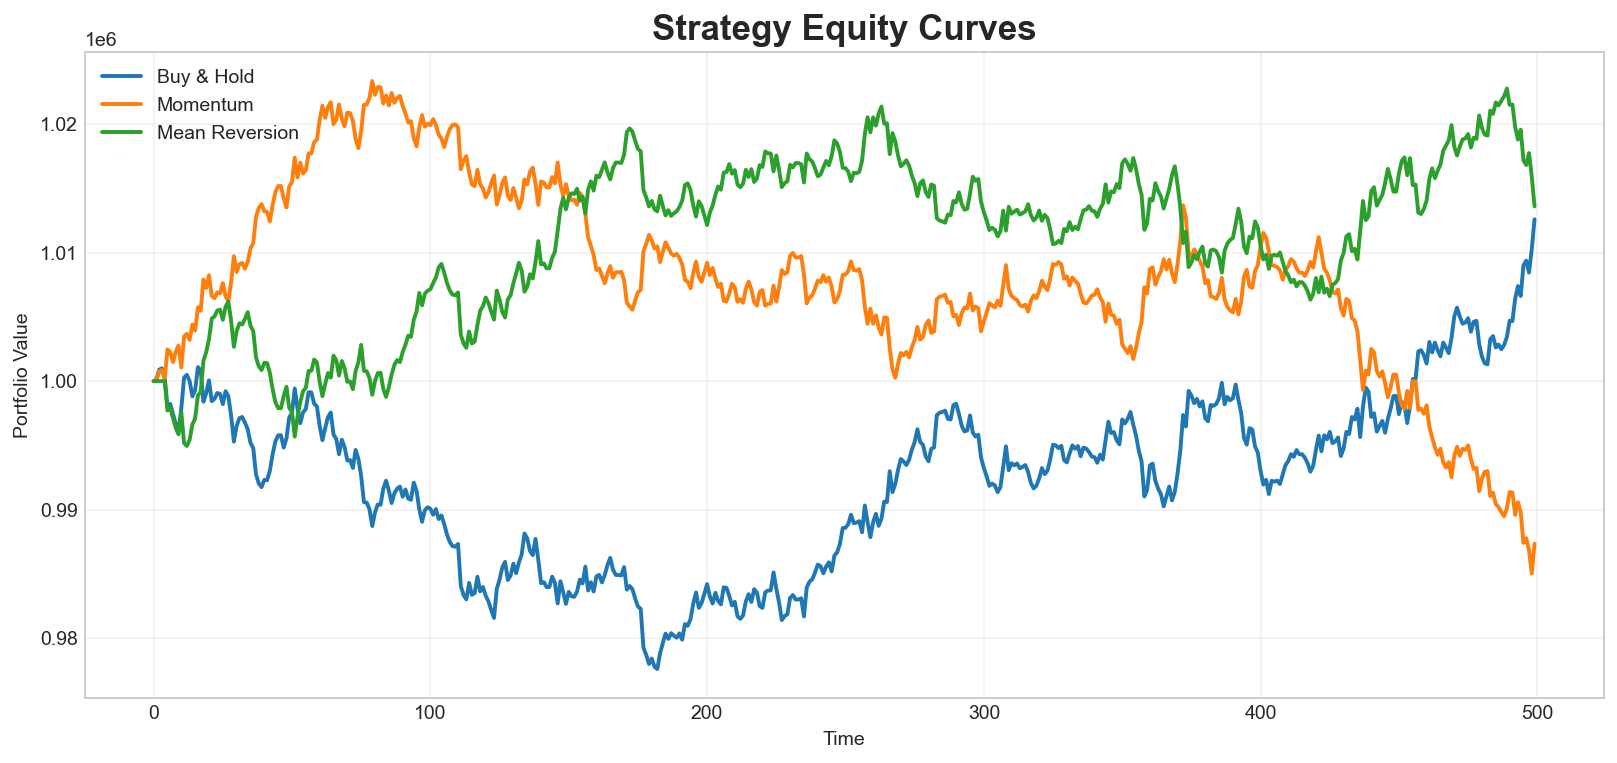

In [126]:
# ============================================================
# 6) PLOT EQUITY CURVES
# ============================================================
plt.figure(figsize=(14, 6), dpi=140)

for name, res in results.items():
    plt.plot(res.index, res["equity"], linewidth=2, label=name)

plt.title("Strategy Equity Curves", fontsize=18, weight="bold")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [127]:
# ============================================================
# 7) PERFORMANCE SUMMARY TABLE
# ============================================================
summary = pd.DataFrame({
    name: {
        "Final Equity": res["equity"].iloc[-1],
        "Return %": (res["equity"].iloc[-1] / res["equity"].iloc[0] - 1) * 100,
        "Max Drawdown": (res["equity"].cummax() - res["equity"]).max(),
        "Sharpe (raw)": res["equity"].pct_change().mean() / res["equity"].pct_change().std()
    }
    for name, res in results.items()
}).T

clean_table(summary)  # or: minimal(summary)


,Final Equity,Return %,Max Drawdown,Sharpe (raw)
Buy & Hold,"1,012,604.7113",1.2605,"23,509.5519",0.0261
Momentum,"987,345.1423",-1.2655,"38,354.6105",-0.0259
Mean Reversion,"1,013,608.7431",1.3609,"15,039.5647",0.0286
